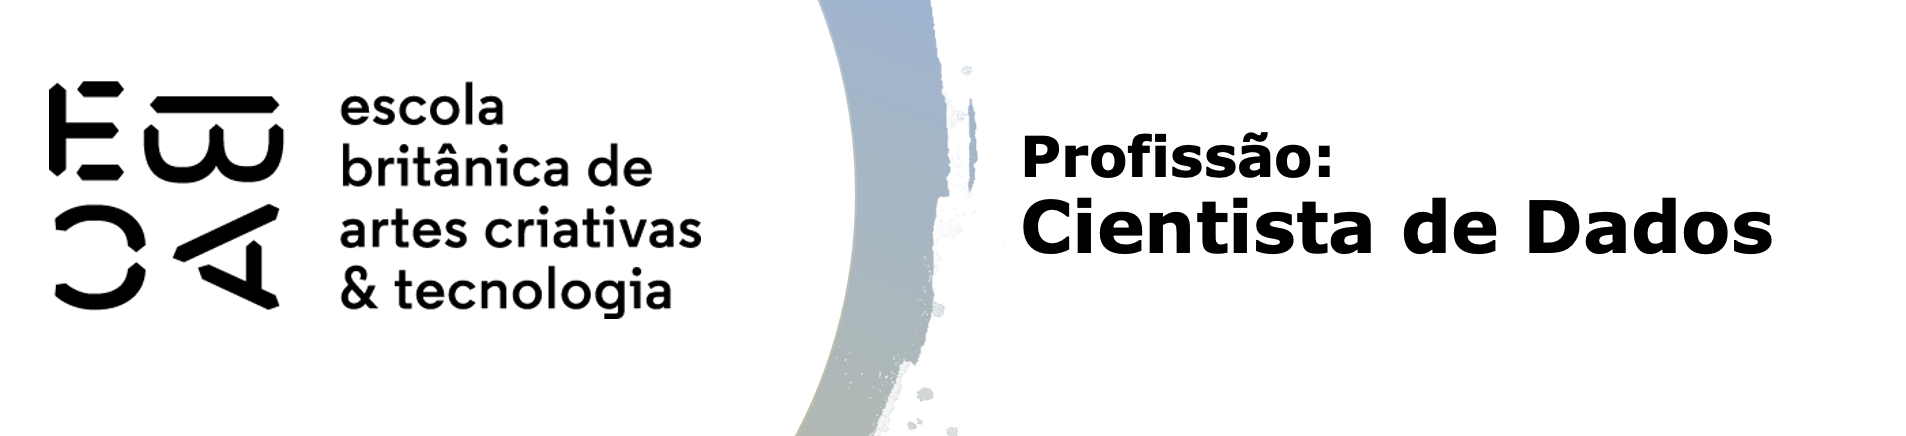

**Professor: Lucas Serra**


# Módulo 24 - Gradient Boosting Machine

In [67]:
import patsy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

from scipy.stats import ks_2samp
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingClassifier

In [68]:
df = pd.read_csv('credit_scoring.csv', parse_dates=['data_ref'])

df['tempo_emprego'].fillna(-1, inplace=True)
df.head()

,data_ref,id_cliente,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,1,F,True,True,0,Assalariado,Secundário,Casado,Casa,49,8.605479,2.0,1916.54,0
1,2015-01-01,2,M,True,False,0,Empresário,Secundário,União,Casa,60,6.953425,2.0,2967.25,0
2,2015-01-01,3,F,True,False,0,Empresário,Secundário,Casado,Casa,28,0.682192,2.0,340.96,0
3,2015-01-01,4,F,False,True,0,Assalariado,Superior completo,Casado,Casa,60,1.879452,2.0,4903.16,0
4,2015-01-01,5,F,False,False,0,Empresário,Secundário,Casado,Casa,47,8.438356,2.0,3012.60,0


#### Bases de desenvolvimento, validação e *out-of-time*

Vamos separar as bases que utilizaremos para desenvolver o modelo (train), *tunar* o modelo (test) e avaliar a performance (val).

In [48]:
# Selecionar meses de 2016 para validação
df_val = df[df['data_ref'] >= datetime(2016, 1, 1)].copy()

# Selecionar meses de 2015 para treinamento e teste
df = df[df['data_ref'] < datetime(2016, 1, 1)]

df_train, df_test = train_test_split(df, test_size=0.3, random_state=12)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

print('Quantidade de linhas no treino:    ', df_train.shape[0])
print('Quantidade de linhas no teste:     ', df_test.shape[0])
print('Quantidade de linhas na validação: ', df_val.shape[0])

Quantidade de linhas no treino:     42000
Quantidade de linhas no teste:      18000
Quantidade de linhas na validação:  15000


In [69]:
equacao = '''mau ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao 
            + estado_civil + tipo_residencia + idade + qt_pessoas_residencia + renda'''

y_train, X_train = patsy.dmatrices(equacao, data=df_train)
y_test, X_test = patsy.dmatrices(equacao, data=df_test)
y_val, X_val = patsy.dmatrices(equacao, data=df_val)

## Métricas para problemas de classificação

Vamos avaliar o desempenho do random forest nas base de treinamento, teste e validação. Vamos avaliar a partir das seguintes métricas KS, Gini, AUC e Acurácia.

#### Função para calcular o desempenho

Para facilitar essas comparações, vamos construir uma função para calcular todos esses indicadores. É interessante colocar valores padrão para os parâmetros da função, assim, vamos poder indicar somente a base de dados para rodar a função com os valores padrão dela.

In [50]:
# Calcular o Gini
def calcula_gini(RESP, PD):
    #AUC
    auc = roc_auc_score(RESP, PD)

    #Gini
    gini = 2 * auc - 1
    return gini


def print_metricas(dados, PD='PD', CLASSE_PRED='classe_predita', RESP='mau'):

    #Acuracia
    acc = accuracy_score(dados[RESP], dados[CLASSE_PRED])

    #AUC
    auc = roc_auc_score(dados[RESP], dados[PD])

    #Gini
    gini = 2 * auc - 1

    #KS
    ks = ks_2samp(dados.loc[dados[RESP] == 1, PD], dados.loc[dados[RESP] != 1,
                                                             PD]).statistic

    print('KS:       {0:.2f}%'.format(ks * 100))
    print('AUC:      {0:.2f}%'.format(auc * 100))
    print('GINI:     {0:.2f}%'.format(gini * 100))
    print('Acurácia: {0:.2f}%\n'.format(acc * 100))

    return None

# *Gradient Boosting*

***Boosting:*** é um método de *ensemble* (mistura de modelos) que tem a finalidade de combinar modelos *fracos* de modo a resultar em um *forte*. A forma mais popular do *boosting* hoje consiste em uma construção sequencial de modelos, cada um tentando reduzir o erro do anterior.

***Gradient Boosting Machine:*** É o algoritmo de *boosting* mais popular. Consiste em construir árvores sequencialmente, em que uma árvore tenta *melhorar* a previsão sobre o erro da anterior. A lógica do algoritmo é a seguinte:

1. Partir da média do target
1. Calcular o resíduo entre a média e o valor do target de cada linha
1. Ajustar uma árvore de decisão na base de desenvolvimento usando o resíduo como target
2. Gravar os *desvios* de previsão em cada observação (resíduos)
3. Ajustar uma nova árvore para explicar os resíduos obtidos em 2
4. Repetir 2, 3, 4 e 5 até atingir um critério de parada

***XGBoosting\:*** (de *extreme gradient boosting*) é uma implementação do *gradient boosting* bastante eficiente e de código aberto, que ficou bastante popular por ser utilizada em diversas implementações de soluções vencedoras em competições de ciência de dados pelo mundo todo. Esta implementação está disponível em Python pelo pacote [XGBoost](https://xgboost.readthedocs.io/en/latest/install.html#python), que não pertence ao scikitlearn (embora o uso seja muito semelhante) e requer instalação utilizando o pip.

## Rodando o *Gradient Boosting Machine*

Vamos rodar abaixo o *Gradient Boosting Machine* pelo scikitlearn.

Além dos parâmetros que já vimos, temos:

***learning_rate (eta)***: este parâmetro tem o intuito de reduzir a contribuição de cada árvore (passo em direção ao target). Com contribuições menores e mais árvores, o algoritmo deve captar padrões mais sutis. Há um equilíbrio entre o ```learning_rate``` e o ```n_estimators```.

In [54]:
%%time
parametros = {
    'n_estimators': 100,
    'max_depth': None,
    'min_samples_leaf': 5,
    'learning_rate': .1,
    'random_state': 22
}

clf = GradientBoostingClassifier(**parametros)\
        .fit(X_train, y_train.ravel())

Wall time: 5min 28s


### Desempenho do GBM

In [55]:
df_train['classe_predita'] = clf.predict(X_train)
df_train['PD'] = clf.predict_proba(X_train)[:, 1]

df_test['classe_predita'] = clf.predict(X_test)
df_test['PD'] = clf.predict_proba(X_test)[:, 1]

df_val['classe_predita'] = clf.predict(X_val)
df_val['PD'] = clf.predict_proba(X_val)[:, 1]

print('Performance do GBM nos dados de treino')
print_metricas(dados=df_train)
print('Performance do GBM nos dados de teste')
print_metricas(dados=df_test)
print('Performance do GBM nos dados de validação')
print_metricas(dados=df_val)

Performance do GBM nos dados de treino
KS:       97.51%
AUC:      99.69%
GINI:     99.39%
Acurácia: 98.03%

Performance do GBM nos dados de teste
KS:       19.41%
AUC:      62.30%
GINI:     24.60%
Acurácia: 91.03%

Performance do GBM nos dados de validação
KS:       20.10%
AUC:      63.54%
GINI:     27.09%
Acurácia: 90.34%



## *GridSearchCV*

### 1o tunning

In [58]:
%%time
from sklearn.model_selection import GridSearchCV

gb = GradientBoostingClassifier()

parametros = {
    'n_estimators': [100, 300, 600],
    'min_samples_leaf': [2, 10, 20],
    'learning_rate': [0.04, 0.06, .1]
}

grid = GridSearchCV(estimator=gb,
                    param_grid=parametros,
                    scoring='roc_auc',
                    verbose=False,
                    cv=2)

grid.fit(X_train, y_train.ravel())

Wall time: 10min 19s


GridSearchCV(cv=2, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.04, 0.06, 0.1],
                         'min_samples_leaf': [2, 10, 20],
                         'n_estimators': [100, 300, 600]},
             scoring='roc_auc', verbose=False)

In [59]:
grid.best_params_

{'learning_rate': 0.04, 'min_samples_leaf': 10, 'n_estimators': 100}

### 2o tunning

In [60]:
%%time
gb = GradientBoostingClassifier()

parametros = {
    'learning_rate': [0.02, 0.03, 0.04],
    'min_samples_leaf': [8, 10, 12],
    'n_estimators': [90, 100, 110]
}

grid = GridSearchCV(estimator=gb,
                    param_grid=parametros,
                    scoring='roc_auc',
                    verbose=False,
                    cv=2)

grid.fit(X_train, y_train.ravel())

Wall time: 3min 10s


GridSearchCV(cv=2, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.02, 0.03, 0.04],
                         'min_samples_leaf': [8, 10, 12],
                         'n_estimators': [90, 100, 110]},
             scoring='roc_auc', verbose=False)

In [61]:
grid.best_params_

{'learning_rate': 0.02, 'min_samples_leaf': 10, 'n_estimators': 100}

### 3o tunning

In [62]:
%%time
gb = GradientBoostingClassifier()

parametros = {
    'learning_rate': [0.01, 0.015, 0.02],
    'min_samples_leaf': [6, 7, 8],
    'n_estimators': [50, 100, 200]
}

grid = GridSearchCV(estimator=gb,
                    param_grid=parametros,
                    scoring='roc_auc',
                    verbose=False,
                    cv=2)

grid.fit(X_train, y_train.ravel())

Wall time: 3min 11s


GridSearchCV(cv=2, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.015, 0.02],
                         'min_samples_leaf': [6, 7, 8],
                         'n_estimators': [50, 100, 200]},
             scoring='roc_auc', verbose=False)

In [63]:
grid.best_params_

{'learning_rate': 0.01, 'min_samples_leaf': 8, 'n_estimators': 100}

### 4o tunning

In [64]:
%%time
gb = GradientBoostingClassifier()

parametros = {
    'learning_rate': [0.008, 0.009, 0.01],
    'min_samples_leaf': [8],
    'n_estimators': [100]
}

grid = GridSearchCV(estimator=gb,
                    param_grid=parametros,
                    scoring='roc_auc',
                    verbose=False,
                    cv=2)

grid.fit(X_train, y_train.ravel())

Wall time: 25.3 s


GridSearchCV(cv=2, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.008, 0.009, 0.01],
                         'min_samples_leaf': [8], 'n_estimators': [100]},
             scoring='roc_auc', verbose=False)

In [65]:
grid.best_params_

{'learning_rate': 0.009, 'min_samples_leaf': 8, 'n_estimators': 100}

## Treinando e calculando a performance dos melhores Hyperparametros

In [70]:
%%time
parametros = {
    'learning_rate': 0.009,
    'min_samples_leaf': 8,
    'n_estimators': 100
}

clf = GradientBoostingClassifier(**parametros)\
        .fit(X_train, y_train.ravel())

df_train['classe_predita'] = clf.predict(X_train)
df_train['PD'] = clf.predict_proba(X_train)[:, 1]

df_test['classe_predita'] = clf.predict(X_test)
df_test['PD'] = clf.predict_proba(X_test)[:, 1]

df_val['classe_predita'] = clf.predict(X_val)
df_val['PD'] = clf.predict_proba(X_val)[:, 1]

print('Performance do GBM nos dados de treino')
print_metricas(dados=df_train)
print('Performance do GBM nos dados de teste')
print_metricas(dados=df_test)
print('Performance do GBM nos dados de validação')
print_metricas(dados=df_val)

Performance do GBM nos dados de treino
KS:       26.67%
AUC:      68.54%
GINI:     37.09%
Acurácia: 93.03%

Performance do GBM nos dados de teste
KS:       26.83%
AUC:      68.58%
GINI:     37.15%
Acurácia: 93.16%

Performance do GBM nos dados de validação
KS:       33.26%
AUC:      72.71%
GINI:     45.43%
Acurácia: 92.88%

Wall time: 9.67 s


In [ ]:
Performance do GBM nos dados de treino
KS:       97.51%
AUC:      99.69%
GINI:     99.39%
Acurácia: 98.03%

Performance do GBM nos dados de teste
KS:       19.41%
AUC:      62.30%
GINI:     24.60%
Acurácia: 91.03%

Performance do GBM nos dados de validação
KS:       20.10%
AUC:      63.54%
GINI:     27.09%
Acurácia: 90.34%

#### Conclusão

O *gradient Boosting* é um algoritmo extremamente poderoso, mas bem mais pesado, delicado e com mais hiperparâmetros. A otimização desse algoritmo pode ser mais custosa, mas levar a melhores resultados.